# Bootstrap sampling

In [1]:
import xarray as xr
import numpy as np
import sys
import random
from scipy import stats
import glob
from resampling import _resample_iterations_idx
from definitions import *  # imports all functions from definitions.py

xr.set_options(
    keep_attrs=True, display_style="html"
)  # Attributes of DataArrays will be kept through operations.

alt = [
    70,
    72,
    74,
    76,
    78,
    80,
    82,
    84,
    86,
    88,
    90,
    92,
    94,
    96,
    98,
    100,
    102,
    104,
    106,
    108,
    110,
    112,
    114,
    116,
    118,
    120,
]
root_path = "/home/gemeinsam_tmp/UA_students/data/PW_GW_analysis/"
dir_path = "/home/hochatmstud/bene/"

In [2]:
def g_kde(y, x):
    """Firstly, kernel density estimation of the probability density function of randomized anomalies.
    Secondly, evaluates the estimated pdf on a set of points.

    Args:
        y (np.array): datapoints to estimate from (randomized anomalies)
        x (np.array): datapoints to be evaluated (composite values)
    Returns:
        np.array: the estimated pdf on composite values
    """
    print(y)
    mask = np.isnan(y)
    kde = stats.gaussian_kde(y[~mask])
    return kde(x)

In [3]:
station = "Leipzig"

In [4]:
# Parameters
station = "RioGrande"

## Wind measurements

In [5]:
ds_wind = read_group("wind", station)

u = read_var(ds_wind, "u0")
v = read_var(ds_wind, "v0")

u_anomalie = anomalie("dayofyear", u)

v_anomalie = anomalie("dayofyear", v)

sea_u = sea(40, station, u)
sea_u_anomalie = sea(40, station, u_anomalie)

sea_v = sea(40, station, v)
sea_v_anomalie = sea(40, station, v_anomalie)

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [6]:
# var = sys.argv[1] # ta, ua ; input variable
time_scale = sys.argv[2]  # 20 or 30 ; input timescale
its = 10000  # 10000 ; number of samples
# what = sys.argv[4] # anomalies ; what kind of anomalies
# DJF_bool = sys.argv[5] # DJF only (bool)
rechunk = True  # allows rechunking in xr.apply_ufunc

if station == "Leipzig":
    size = 7
elif station == "Esrange":
    size = 11
elif station == "Sodankyla":
    size = 4
elif station == "Sodankyla_Kiruna":
    size = 11
elif station == "CMOR":
    size = 9
elif station == "RioGrande":
    size = 4
elif station == "Davis":
    size = 7

line_width = 5

In [7]:
# u_anomalie
u_anomalie["name"] = "statistical significance"

### for-loop via the lags

In [8]:
u_anomalie = u_anomalie.sel(alt=slice(80, 100)).dropna("time")

In [9]:
sea_u_anomalie = sea_u_anomalie.sel(alt=slice(80, 100)).dropna("days")

In [10]:
p = []

for lag in range(-40, 41, 1):
    # print(comp_name, size)
    # samples generation (loaded from external function)
    rnd_arr = _resample_iterations_idx(
        u_anomalie, its, "time", replace=True, chunk=False, dim_max=size
    )
    # print(rnd_arr)
    print("".ljust(line_width) + "{} samples generated".format(its))
    ## load of composite dataarray
    # comp_file = f'{root_path}composites_woSSW{w_clim}/{var}_{what}_comp_{comp_name}_{time_scale}days.nc'
    # ds_comp = xr.open_dataarray(comp_file)*factor
    # print("".ljust(line_width)+'{} opened'.format(comp_file))

    # statistical significance calculation (vectorized g_kde)
    da_kde = xr.apply_ufunc(
        g_kde,
        rnd_arr,
        sea_u_anomalie.sel(days=lag),
        input_core_dims=[["iteration"], []],
        vectorize=True,
        dask="parallelized",
        exclude_dims=set(("iteration",)),
        output_core_dims=[[]],
        output_dtypes=[sea_u_anomalie["u0_mean"].dtype],
    )
    print("".ljust(line_width) + "p-values calculated")
    # output the calculation
    # outfile_name = f'{dir_path}bootstrap_test_{station}_lag_{lag}.nc'
    da_kde["name"] = u_anomalie["name"]
    # da_kde.to_netcdf(outfile_name)
    # print("".ljust(line_width)+'{} saved'.format(outfile_name))
    # del da_kde, rnd_arr, ds_comp
    # print()
    # da_kde.plot.scatter(y='alt', x='u0_mean')
    # da_kde.plot.scatter(y='alt', x='u0_std')
    p.append(da_kde)

     10000 samples generated
[-6.22957197  1.89643939  6.91249053 ... -3.98102273 -2.7576875
 -5.95173485]
[-5.7060303   0.28054924  6.40053977 ... -5.80683333 -3.301875
 -4.91305303]
[-6.33592235 -1.52142045  6.09055871 ... -7.06611174 -3.11822917
 -5.42600758]
[-6.19391667 -2.91445076  5.10890152 ... -6.61201326 -2.43308333
 -6.48327462]
[-6.7815928  -3.47366477  3.73205492 ... -4.90080871 -1.04960417
 -7.68212689]
[-7.11179735 -3.56052083  2.04039773 ... -2.99796402  0.45795833
 -8.46886553]
[-6.61299242 -4.1886553   0.18061553 ... -1.15618371  1.45504167
 -8.50195076]
[-5.85145455 -3.86356061 -1.29477273 ... -0.59241477  2.27391667
 -8.27553409]
[-4.86802652 -3.62045455 -2.35877841 ... -0.90159091  2.53010417
 -7.5215625 ]
[-3.59096212 -3.63453598 -2.85496212 ... -0.98480871  2.5884375
 -6.12020265]
[-2.234125   -2.43821023 -3.40703598 ... -0.28252273  2.6068125
 -3.90472159]
[-6.22957197  1.89643939  6.91249053 ... -3.98102273 -2.7576875
 -5.95173485]
[-5.7060303   0.28054924  6.4

     10000 samples generated
[ 1.12805871 -7.27821591 -2.75015152 ...  8.01196023  2.37164962
  9.92427083]
[ 1.86410038 -9.8852197  -2.86252841 ...  9.06886364  2.39339583
  8.3704375 ]
[  2.40434659 -11.58750189  -2.89875    ...   8.89804924   2.21089015
   6.37375   ]
[  2.77447917 -11.4760947   -3.21875    ...   8.03851326   2.16256818
   4.162125  ]
[  2.87694129 -10.67551894  -3.96623106 ...   7.01345644   2.0687197
   1.69004167]
[ 3.13379735 -9.47249811 -5.10206439 ...  5.28632576  1.88892235
 -0.0171875 ]
[ 3.22673295 -7.69993182 -6.37136364 ...  3.42751894  1.9664375
 -2.27972917]
[ 3.36149621 -6.54802841 -6.86282197 ...  1.5066572   2.0669053
 -4.378375  ]
[ 2.79022727 -5.14077083 -6.56357955 ... -0.20750947  2.36471023
 -5.6791875 ]
[ 2.39749053 -3.5140303  -6.43298295 ... -1.77964962  1.84032576
 -6.57908333]
[ 2.70099432  0.23278598 -7.10608902 ... -2.20192235  0.91053788
 -5.81116667]
[ 1.12805871 -7.27821591 -2.75015152 ...  8.01196023  2.37164962
  9.92427083]
[ 1.8641

[-8.71018939 -2.78512311  2.12708333 ... -6.79017045 -2.41770833
 -2.95666667]
[-7.1439678  -2.82717803  1.44510417 ... -6.1491572  -3.80979167
 -1.90491098]
[-6.8854072  -2.296875    1.93385417 ... -5.17901515 -4.6275
 -0.63811174]
[-6.59172348 -1.21394886  1.58114583 ... -4.17748106 -4.4865625
  0.50967235]
     p-values calculated
     10000 samples generated
[ 0.6015      0.330625    0.00969697 ... -3.233625   -7.12537879
  2.73666667]
[ 0.942375   -0.8784375  -0.18993371 ... -4.70245833 -7.59371212
  4.3071875 ]
[ 2.849375   -1.22145833 -0.77247159 ... -6.89722917 -8.55392992
  4.50375   ]
[ 4.8685625  -1.6346875  -1.77045455 ... -8.34358333 -8.8355303
  4.14416667]
[ 5.83116667 -1.84791667 -3.62383523 ... -8.70177083 -8.24088068
  3.30229167]
[ 6.14114583 -2.230625   -5.98782197 ... -8.98760417 -7.42888258
  1.753125  ]
[ 6.20070833 -2.7109375  -7.77892992 ... -8.4459375  -5.81161932
  0.01604167]
[ 5.58255303 -3.001875   -8.51358902 ... -7.55435417 -3.79735795
 -1.80791667]
[ 4.

     10000 samples generated
[ -2.7302178    4.30635417   2.37045139 ...   1.8908428  -14.14451894
  -1.8446875 ]
[ -1.3757197    3.7571875    2.38590278 ...   1.18617424 -12.90952083
  -2.52208333]
[ -0.7179072    4.17510417   2.84309028 ...  -0.92198864 -11.8614375
  -3.50052083]
[  0.41742424   3.7325       2.54138889 ...  -3.48126894 -10.79935985
  -4.2028125 ]
[ 1.26632576  3.38270833  0.56173611 ... -5.19844697 -9.53942614
 -3.95739583]
[ 3.39762311  2.87197917 -0.94173611 ... -5.98576705 -8.23264205
 -3.17208333]
[ 5.35285985  1.46229167 -2.65961806 ... -6.13693182 -6.12910038
 -3.263125  ]
[ 6.39159091  0.575      -4.22413194 ... -6.35066288 -3.85331439
 -3.71395833]
[ 5.84898674 -0.29364583 -5.46940972 ... -6.24744318 -1.52140152
 -4.1325    ]
[ 4.68756629 -1.99958333 -5.86194444 ... -5.77746212  0.03369508
 -3.44104167]
[ 3.44975379 -2.99072917 -5.83295139 ... -3.83820076  1.90977462
 -2.4528125 ]
[ -2.7302178    4.30635417   2.37045139 ...   1.8908428  -14.14451894
  -1.8446

[ 2.255625   -1.22046402 -7.56310606 ... -6.77409659 -0.21289773
 -1.04832955]
[-10.17875     -3.25195076  -4.43449811 ...   1.2267803   -1.00371843
  -6.33123864]
[-9.14854167 -2.71339015 -3.54910038 ... -1.93407576 -2.57525253
 -5.72507955]
[-7.89875    -2.3911553  -3.22080492 ... -4.69907197 -4.38153093
 -5.31339773]
[-5.67208333 -2.53227273 -3.86249053 ... -7.06551894 -5.47923927
 -5.181     ]
[-2.7575     -2.8929072  -4.11872159 ... -9.62205114 -5.3300726
 -5.63145455]
[  0.50385417  -2.25100379  -4.83091856 ... -11.33235038  -4.9340846
  -5.48348864]
[  3.29958333  -1.25862689  -5.23675189 ... -12.30516098  -4.17858586
  -4.80307955]
[  4.45208333  -1.1540625   -5.22323864 ... -11.43918371  -2.70111742
  -3.80027273]
[ 4.4346875  -1.01414773 -5.33193182 ... -8.75446402 -1.52045455
 -2.50875   ]
[ 3.610625   -1.30517045 -6.46851326 ... -7.30506629 -0.86458333
 -1.22280682]
[ 2.255625   -1.22046402 -7.56310606 ... -6.77409659 -0.21289773
 -1.04832955]
     p-values calculated
     

[ 3.22041667 11.95236742 -5.79547917 ...  5.60591856 -4.9228125
 -5.96411932]
[ 1.84127841 11.21125    -6.06106439 ...  8.92244318 -4.83972917
 -5.13658144]
[ 0.44059659 10.6253125  -5.34121023 ... 10.27012311 -3.26122917
 -5.06080492]
[-0.50150568  9.49897727 -3.80106818 ... 11.08089015 -3.59703472
 -4.24559659]
[-0.58747159  8.59244318 -3.16539205 ... 10.8565625  -2.99993056
 -3.30857008]
     p-values calculated
     10000 samples generated
[ 4.51091667 -2.03191288  1.12798295 ... -0.78792298  0.69695076
  8.55570391]
[ 4.17077083 -3.478125    2.17910985 ...  1.05296717  2.06291667
  7.51136048]
[ 4.3079375  -5.08477273  2.781875   ...  2.78231376  2.40852652
  6.3015404 ]
[ 4.53839583 -6.51267992  3.92189394 ...  4.23663194  2.18098485
  5.44062816]
[ 4.85335417 -8.02736742  4.05139205 ...  5.43575126  1.83953788
  4.79578283]
[ 4.62314583 -7.44154356  2.92179924 ...  5.86845328  0.31861742
  5.62435922]
[ 3.8224375  -5.51188447  1.44431818 ...  4.9897096  -0.98778598
  5.64629419]

[-4.47998106 -1.70101705  1.37815152 ...  2.45817045 -1.2895625
 -8.14375   ]
[-3.58833333 -2.24624621 -0.14461553 ...  1.35380303 -1.52270833
 -7.903     ]
[-3.11045455 -2.45514962 -1.21497159 ...  0.01798295 -1.24116667
 -5.80810417]
[-3.07368371 -3.01546212 -1.35233523 ...  0.25218182 -0.522375
 -5.25583333]
[-3.46971591 -3.3122803  -2.95203977 ... -0.80366856  0.03835417
 -4.91166667]
     p-values calculated
     10000 samples generated
[  5.685625    -0.36811553   3.22993056 ...   6.10492045 -18.30917614
  11.81936932]
[  6.244375    -1.69445076   4.27291667 ...   3.28584091 -20.54765152
  10.62745644]
[  6.57791667  -2.57477273   5.45274306 ...   0.16834091 -21.78016098
   9.10719318]
[  6.23114583  -2.87288826   6.43777778 ...  -2.98782955 -21.51758523
   6.80180682]
[  4.400625    -3.06818182   7.11572917 ...  -5.406625   -20.49764205
   4.81153788]
[  2.83854167  -3.59319129   6.94229167 ...  -6.15570455 -17.93285038
   2.92583144]
[  1.48291667  -4.28198864   6.42131944 ... 

[ 0.08050189  4.26358333  2.52061174 ... -2.20999053  3.16820076
 -1.63114583]
[ 0.06853409  3.04854167  2.16885606 ... -1.36536932  1.2230303
 -0.73989583]
[ 0.15543939  1.08079167  1.93484659 ... -0.93038826 -0.32381629
  0.901875  ]
[ 0.23622917 -1.24577273  2.52529924 ... -0.75714015 -1.40366477
  2.2496875 ]
[ 0.65998485 -6.70664205  2.26013636 ... -0.74961174 -1.06933712
  3.06729167]
     p-values calculated
     10000 samples generated
[ 6.77407197 -3.24784091  5.12994318 ...  3.56012311  1.3472822
  8.32870833]
[ 5.31778409 -2.07192235  3.54717803 ...  5.04250947  1.15583333
  6.48377083]
[ 3.34581439 -0.52858902  2.72295455 ...  6.24852273  0.95515152
  3.38316667]
[2.15089015 0.67346591 2.34008523 ... 6.99410985 1.0653125  0.17454167]
[ 1.43668561  1.37785985  2.1624053  ...  7.7796875   1.27629735
 -2.88116667]
[ 1.02761364  1.96770833  2.41787879 ...  7.6722822   1.18295455
 -5.38258333]
[ 0.11073864  2.43952652  3.2836553  ...  6.51654356  0.63522727
 -7.39514583]
[-1.330

     10000 samples generated
[-1.67049242  4.32375     0.09359848 ... -9.14731061  3.86732008
  6.51058333]
[-2.04362689  6.004375    2.03872159 ... -8.54874053  5.62413826
  5.39540152]
[-2.36755682  7.27        4.48314394 ... -6.40354167  6.20619318
  4.36727273]
[-2.75607955  8.00927083  5.77370265 ... -4.33675189  5.62645833
  4.18996591]
[-2.63277462  8.2946875   6.04114583 ... -3.35270833  2.96870265
  4.5184678 ]
[-1.81242424  7.54385417  5.78342803 ... -2.30097538 -0.26556818
  4.60663068]
[-1.55787879  6.65833333  5.61311553 ... -1.17059659 -3.39648674
  4.12747727]
[-1.67714015  5.2259375   5.85501894 ... -1.15787879 -4.83746212
  3.24838258]
[-0.96912879  3.85375     5.29488636 ... -1.22909091 -4.13982008
  2.40514015]
[-0.03508523  2.94770833  3.7452178  ... -1.58001894 -2.33423295
  0.68096212]
[ 0.05691288  2.486875    1.84473485 ... -1.8961553  -0.00633523
 -1.12520455]
[-1.67049242  4.32375     0.09359848 ... -9.14731061  3.86732008
  6.51058333]
[-2.04362689  6.004375 

  1.98267045]
[-4.30359848  3.36765909 -0.5996875  ...  3.75305871 -5.74410417
  3.71055871]
[-6.24761364  2.25126326 -1.16023674 ...  1.33378788 -8.05395833
  5.61827652]
[-8.17313447  1.66399242 -0.85297348 ... -0.56954545 -9.52779167
  7.39628788]
[ -9.81625      1.77799621   0.14107955 ...  -4.10477273 -10.3379375
   9.00345644]
[-11.63652462   2.1250303    1.60180871 ...  -7.7184375   -9.66695833
   9.99756629]
[-12.00675189   1.74087689   2.66788826 ... -10.59273674  -7.98585417
  11.15064394]
[-11.23630682   0.63069508   3.0578125  ... -12.52370265  -5.62810417
  11.93908144]
[-10.04892045  -0.33658902   3.51872159 ... -13.24497159  -3.51558333
  11.50621212]
[ -8.62910038  -0.9801875    4.45791667 ... -12.76832386  -1.55422917
   9.79035985]
[ -7.40142992  -1.17600189   5.44367424 ... -11.56439394   0.62497917
   8.05936553]
[-2.68650568  4.89405303  0.52405303 ...  6.81518939 -3.3655
  1.98267045]
[-4.30359848  3.36765909 -0.5996875  ...  3.75305871 -5.74410417
  3.71055871]
[

[-3.10188068  1.24787879 -0.31581439 ...  0.8425      2.11970644
  3.854375  ]
[-3.04653409  0.43568182 -1.16374053 ...  1.27058712  1.43119318
  2.29195076]
[-2.04905303  0.26529356 -0.96931818 ...  1.18151515  1.38007576
  1.46863636]
[-0.60175758 -0.16302083 -0.50591856 ...  1.00544508  1.89827652
  0.6444697 ]
[ 0.11153977 -0.54434659 -0.35419508 ...  0.74625947  2.23811553
 -0.40082386]
[ 0.27792235 -0.46800189  0.5183428  ...  0.80306818  3.21142045
 -1.39588068]
[-0.04008712 -0.42851326  1.31855114 ...  0.67056818  3.96767045
 -1.78693182]
[ 0.12222917 -0.13719697  2.34551136 ...  0.47611742  3.32194129
 -2.11248106]
[ 0.22023485  0.1639678   2.78140152 ...  1.54025568  2.06849432
 -3.44423295]
     p-values calculated
     10000 samples generated
[-2.67974432 -4.57078598 -2.02606061 ... -0.22795455  0.12607008
 -5.69035985]
[-1.16682765 -3.34360795 -1.27813447 ... -0.77947917 -2.25851326
 -4.18460227]
[ 1.22451705 -1.18364583 -0.35601326 ... -1.29685606 -4.37864583
 -1.94555871

     10000 samples generated
[ 6.40507386  0.77920581  6.35072917 ... -5.32302083 -3.34938447
 -6.03999053]
[ 5.33539205  2.01044571  5.90208333 ... -5.0184375  -3.82120265
 -5.09639205]
[ 4.82051705  2.8013529   3.72583333 ... -4.1921875  -3.26299242
 -3.74277462]
[ 5.2255322   4.23171338  0.74572917 ... -2.67541667 -2.97964962
 -2.52482008]
[ 5.36113068  4.61553851 -0.2403125  ... -0.9571875  -2.39328598
 -1.62907197]
[ 5.22383333  4.22359407 -0.18135417 ...  0.08270833 -1.44211174
 -0.25211174]
[ 4.64368371  3.13404419 -0.19802083 ...  1.4009375   0.18345644
  1.27696023]
[ 3.80698485  0.99841982 -0.36041667 ...  2.035625    1.34563447
  2.6647822 ]
[ 2.62630682 -1.40230997 -0.17229167 ...  2.79510417  2.22005682
  3.17183712]
[ 0.71180492 -2.83824306 -0.4615625  ...  3.04822917  2.64005682
  2.70791667]
[-1.85105114 -3.60152778 -1.18791667 ...  2.57333333  2.46885417
  2.44672348]
[ 6.40507386  0.77920581  6.35072917 ... -5.32302083 -3.34938447
 -6.03999053]
[ 5.33539205  2.0104457

[ 5.68277462  0.51972538  2.46836553 ... -1.25989583 -7.12373106
 -3.78979167]
[ 6.35267045 -0.7156553   2.58492045 ... -3.9425     -6.82051136
 -3.25177083]
[ 6.28777462 -1.72954356  2.81588826 ... -6.02520833 -5.58564394
 -1.92645833]
[ 5.24213068 -2.5979697   2.55926326 ... -6.97364583 -4.34418561
 -0.244375  ]
[ 3.53894886 -3.57979167  1.80189015 ... -7.3365625  -3.05797348
  1.74625   ]
[ 2.13398674 -3.35315152  1.29670265 ... -7.55458333 -1.84679924
  3.955625  ]
[ 1.59173295 -2.28415341  1.12017614 ... -8.3240625  -0.72
  5.07447917]
[ 1.27875    -1.29085417  1.97180682 ... -7.93166667  0.05999053
  5.19239583]
[ 1.19387311 -0.77875758  3.32611174 ... -6.60010417  0.09911932
  3.93979167]
     p-values calculated
     10000 samples generated
[-9.07516477 -5.9971875  19.16345644 ...  3.09052083  2.56924242
  0.84960227]
[-10.22977462  -4.715       15.58708333 ...   1.44581439   1.44257576
   0.93660038]
[-10.50614962  -3.0321875   11.97315341 ...   1.23321023   0.04738636
   0.29

In [11]:
p_comp = xr.concat(p, dim="days")
p_comp["days"] = range(-40, 40 + 1)
p_comp = p_comp.where(p_comp["u0_mean"] < 0.05, other=-0.05)

In [12]:
# p_comp

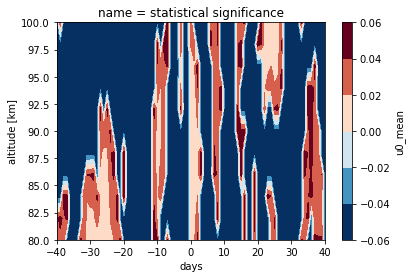

In [13]:
p_comp["u0_mean"].plot.contourf(x="days")